## Imitative Learning: IL  in cartpole
模仿学习

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
  
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
    
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    done = terminated or truncated
    self.step_n += 1
    if self.step_n >= 200:
      done = True
    return state, reward, done, info 
  
env = MyWrapper()
env.reset()

array([-0.03096395, -0.03150868,  0.04155564,  0.03748439], dtype=float32)

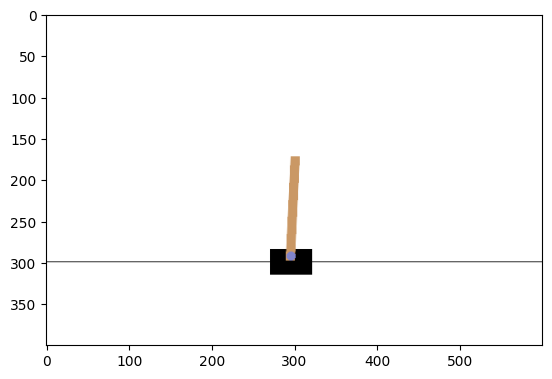

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

# 打印游戏
def show():
  plt.imshow(env.render())
  plt.show()
  
show()

In [4]:
import torch
import random
from IPython import display

# 教师模型使用PPO
class PPO:
	def __init__(self):
		# 定义模型
		self.model = torch.nn.Sequential(
			torch.nn.Linear(4, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 2),
			torch.nn.Softmax(dim=1),
		)

		self.model_td = sequential = torch.nn.Sequential(
			torch.nn.Linear(4, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 1)
		)
		self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
		self.optimizer_td = torch.optim.Adam(self.model_td.parameters(), lr=1e-2)
		self.loss_fn = torch.nn.MSELoss()
  
  # 得到一个动作
	def get_action(self, state):
		# 走神经网络，得到一个动作
		state = torch.FloatTensor(state).reshape(1, 4)
		# [1, 4] -> [1, 2]
		prob = self.model(state)
		
		# 根据概率选择一个动作
		action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]
		
		return action

	# 优势函数
	def _get_advantages(self, deltas):
		advantages = []
		
		# 反向遍历deltas
		s = 0.0
		for delta in deltas[::-1]:
			s = 0.98 * 0.95 * s + delta
			advantages.append(s)
			
		# 逆序
		advantages.reverse()
		return advantages

	def train(self, states, rewards, actions, next_states, overs):
		# 玩一局游戏，得到数据
		# states -> [b, 4]
		# rewards -> [b, 1]
		# actions -> [b, 1]
		# next_states -> [b, 4]
		# overs -> [b, 1]
	
		# 计算values, targets
		# [b, 4] -> [b, 1]
		values = self.model_td(states)
		
		# [b, 4] -> [b, 1]
		targets = self.model_td(next_states) * 0.98
		targets *= (1 - overs)
		targets += rewards
		
		# [b, 1]
		deltas = (targets - values).squeeze(dim=1).tolist()
		advantages = self._get_advantages(deltas)
		advantages = torch.FloatTensor(advantages).reshape(-1, 1)
		
		# 取出每步动作的概率
		# [b, 2] -> [b, 2] -> [b, 1]
		old_probs = self.model(states)
		old_probs = old_probs.gather(dim=1, index=actions)
		old_probs = old_probs.detach()
		
		# 每个批量反复训练10次
		for _ in range(10):
			#[b, 4] -> [b, 2]
			new_probs = self.model(states)

			# [b, 2] -> [b, 1]
			new_probs = new_probs.gather(dim=1, index=actions)
			new_probs = new_probs
			
			# [b, 1] - [b, 1] -> [b, 1]
			ratios = new_probs / old_probs
			
			# 计算截断和不接段的两份loss, 取小的
			# [b, 1] * [b, 1] -> [b, 1]
			surr1 = ratios * advantages
  
			# [b, 1] * [b, 1] -> [b, 1]
			surr2 = torch.clamp(ratios, 0.8, 1.2) * advantages
			
			loss = -torch.min(surr1, surr2)
			loss = loss.mean()
			
			# 重新计算value和时序差分
			values = self.model_td(states)
			loss_td = self.loss_fn(values, targets.detach())
			
			# 更新参数
			self.optimizer.zero_grad()
			loss.backward()
			self.optimizer.step()
			
			self.optimizer_td.zero_grad()
			loss_td.backward()
			self.optimizer_td.step()
      
  # 得到一局游戏的数据
	def get_data(self):
		states = []
		rewards = []
		actions = []
		next_states = []
		overs = []
		
		
		# 初始化游戏
		state = env.reset()
		
		# 玩到游戏结束为止
		over = False
		while not over:
			# 根据当前状态得到一个动作
			action = self.get_action(state)
			
			# 执行动作，得到反馈
			next_state, reward, over, _ = env.step(action)
			
			# 记录数据样本
			states.append(state)
			rewards.append(reward)
			actions.append(action)
			next_states.append(next_state)
			overs.append(over)
			
			# 更新游戏状态，开始下一个动作
			state = next_state
			
		# [b, 4]
		states = torch.FloatTensor(states).reshape(-1, 4)
		# [b, 1]
		rewards = torch.FloatTensor(rewards).reshape(-1, 1)
		# [b, 1]
		actions = torch.LongTensor(actions).reshape(-1, 1)
		# [b, 4]
		next_states = torch.FloatTensor(next_states).reshape(-1, 4)
		# [b, 1]
		overs = torch.LongTensor(overs).reshape(-1, 1)
		
		return states, rewards, actions, next_states, overs

	def test(self, play):
		#初始化游戏
		state = env.reset()
		
		#记录反馈值的和,这个值越大越好
		reward_sum = 0
		
		#玩到游戏结束为止
		over = False
		while not over:
			#根据当前状态得到一个动作
			action = self.get_action(state)
			
			#执行动作,得到反馈
			state, reward, over, _ = env.step(action)
			reward_sum += reward
			
			# 打印动画
			if play and random.random() < 0.2: # 跳帧
				display.clear_output(wait=True)
				show()
				
		return reward_sum

teacher = PPO()

teacher.train(*teacher.get_data())

teacher.get_action([1, 2, 3, 4]), teacher.test(play=True)

(0, 9.0)

In [5]:
for i in range(500):
  teacher.train(*teacher.get_data())
  
  if i % 50 == 0:
    test_result = sum([teacher.test(play=False) for _ in range(10)]) / 10
    print(i, test_result)
    
teacher.test(play=False)

0 16.2
50 183.8
100 200.0
150 200.0
200 200.0
250 200.0
300 200.0
350 200.0
400 200.0
450 200.0


200.0

In [7]:
# 使用训练好的模型获取一批教师数据
teacher_states, _, teacher_actions, _, _ = teacher.get_data()

# 删除教师，只留下教师的数据就可以了
del teacher

teacher_states.shape, teacher_actions.shape

(torch.Size([200, 4]), torch.Size([200, 1]))

In [8]:
# 初始化学生模型
student = PPO()

student

In [9]:
# 定义鉴别器网络，鉴定一批数据来自teacher还是student
class Discriminator(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.sequential = torch.nn.Sequential(
			torch.nn.Linear(6, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 1),
			torch.nn.Sigmoid(),
		)
    
  def forward(self, states, actions):
    one_hot = torch.nn.functional.one_hot(actions.squeeze(dim=1), num_classes=2)
    cat = torch.cat([states, one_hot], dim=1)
    return self.sequential(cat)
  
discriminator = Discriminator()
discriminator(torch.randn(2, 4), torch.ones(2, 1).long())

tensor([[0.5866],
        [0.5859]], grad_fn=<SigmoidBackward0>)

In [10]:
# 模仿学习
def imi_learn():
  optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
  bce_loss = torch.nn.BCELoss()
  
  for i  in range(500):
    # 使用Student模型获取一句游戏的数据，不需要reward
    states, _, actions, next_states, overs = student.get_data()
    
    # 使用鉴别器鉴定两批数据的来源
    prob_teacher = discriminator(teacher_states, teacher_actions)
    prob_student = discriminator(states, actions)
    
    # 老师0，学生1，计算二分类loss
    loss_teacher = bce_loss(prob_teacher, torch.zeros_like(prob_teacher))
    loss_student = bce_loss(prob_student, torch.ones_like(prob_student))
    loss = loss_teacher + loss_student
    
    # 调整鉴别器
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 使用一批数据来自学生的概率作为reward,取log,再符号取反
    # 因为鉴别器会把学生数据的概率贴近1,所以目标是让鉴别器无法分辨,这是一种对抗网络的思路
    rewards = -prob_student.log().detach()
    
    # 更新学生模型参数,使用PPO模型本身的更新方式
    student.train(states, rewards, actions, next_states, overs)
    
    if i % 50 == 0:
      test_result = sum([student.test(play=False) for _ in range(10)]) / 10
      print(i, test_result)
      
imi_learn()

0 19.4
50 195.7
100 182.1
150 196.3
200 200.0
250 200.0
300 200.0
350 200.0
400 200.0
450 200.0


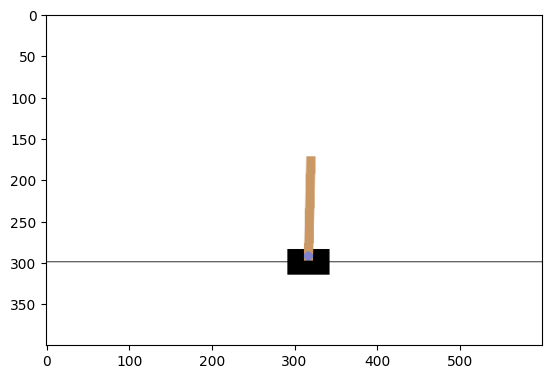

200.0

In [11]:
student.test(play=True)